In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.datasets import load_digits
import time
from sklearn import svm
from sklearn.model_selection import GridSearchCV 
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from scipy.stats import sem
from numpy import linalg as LA
from copy import deepcopy
import warnings
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")

In [2]:
def compute_margin(X, y, w, b):
    margin = []
    for i in range(y.shape[0]):
        margin.append((y[i]*(np.dot(X[i,:], w)+b))/sqrt(sum(w**2))) 
    if min(margin) >= 0:
        return min(margin)
    return 0

In [3]:
import random
from sklearn.base import BaseEstimator, ClassifierMixin
class IM_ELM(BaseEstimator, ClassifierMixin):

    # Inicialization of important parameters 
    def __init__(self, n_neurons, eta=0.1, lambda_param=0.1, delta_margin=10^-3,
                 IMA_iterations=10, max_updates=10000):
        self.n_neurons = n_neurons              # Neurons of hidden layer osf ELM
        self.eta = eta                          # Learning rate
        self.lambda_param = lambda_param        # Param important of soft margin
        self.delta_margin = delta_margin        # (1 + delta_margin) * fixed margin defines the minimum next margin of IMA
        self.IMA_iterations = IMA_iterations    # Maximum number of iterations of IMA
        self.max_updates = max_updates          # Maximum number of updates in one execution of FMP
        self.w = np.array([])                   # Vector of weights of the last layer of the ELM obtained after the training of the IMA
        self.w_elm = np.array([])               # Vector of weights of the last layer of the ELM obtained after the normal training of ELM
        self.H = np.array([])                   # H matrix of ELM (obtained with training data)
        self.Z = np.array([])                   # Z matrix of ELM
        self.b = 0

    # Fixed Margin Algorithm    
    def FMP_algorithm(self, X, y, w_init, b_init, fixed_margin, idx, s):
        t = 0
        iterations = 0
        w = w_init
        b = b_init
        norm_w = sqrt(sum(w**2))
        last_t = -1
        lambda_t = 0
        alpha = np.zeros((X.shape[0]))
        while True:
            last_t = t
            e=0
            for k in range(0, y.shape[0]):
                i = int(idx[k])
                if(y[i]*(np.dot(X[i,:], w)+b) <= fixed_margin * norm_w - self.lambda_param * alpha[i]):
                    if norm_w != 0:
                        lambda_t = 1 - (self.eta*fixed_margin)/norm_w
                    else:
                        lambda_t = 1
                    alpha = alpha * lambda_t
                    alpha[i] = alpha[i] + self.eta    
                    w = w * lambda_t + self.eta * y[i] * X[i,:]
                    norm_w = sqrt(sum(w**2))
                    b = b + self.eta*y[i]
                    t += 1
                    e += 1
                    if k > s:
                        s += 1
                        j = s
                    else:
                        j=e
                    idx[k], idx[j] = idx[j], idx[k]
            iterations += 1
            if (t > self.max_updates or last_t == t):
                break
        if t<= self.max_updates:
            convergence=1
        else:
            convergence=0
        return w, b, convergence, t, iterations, idx, s

    # IMA Algorithm
    def IM_algorithm(self, X, y):
        self.w = np.zeros(self.w_elm.shape[0])
        self.ws = [] 
        self.bs = [] 
        self.ws.append(self.w)
        self.bs.append(self.b)
        fixed_margin = 0#compute_margin(X, y, self.w_elm, self.b)
        t = 0
        convergence = 1
        updates=0
        iterations=0
        margin=[]
        margin.append(fixed_margin)
        idx = np.linspace(0, y.shape[0]-1, y.shape[0])
        s=0
        l=0
        while convergence==1 and t<self.IMA_iterations:
            w, b, convergence, updates_, iterations_, idx, s = self.FMP_algorithm(X, y, self.w, self.b, fixed_margin, idx, s)
            if convergence == 1:
                self.w = w
                self.b = b
                self.ws.append(self.w)
                self.bs.append(self.b)
            updates += updates_
            iterations += iterations_
            norm_w = sqrt(sum(self.w**2))
            gamma1 = []
            gamma2 = []
            for i in range(0, y.shape[0]):
                if y[i] == 1:
                    gamma1.append((y[i]*(np.dot(X[i], self.w)+self.b))/norm_w)
                else:
                    gamma2.append((y[i]*(np.dot(X[i], self.w)+self.b))/norm_w)
            if max(gamma1) < 0 or len(gamma1) == 0:
                gamma1.append(0)
            if max(gamma2) < 0 or len(gamma2) == 0:
                gamma2.append(0)
            fixed_margin = max([(min(gamma1) + min(gamma2))/2, 
                                (1+self.delta_margin)*fixed_margin])
            margin.append(compute_margin(X, y, self.w, self.b))
            #if l > 0:
            #    self.eta = sqrt(l/updates_) * self.eta
            #    print(self.eta)
            #l = updates_
            t += 1
        return t, updates, iterations, margin

    # Function that manage the training of IMA ELM
    def fit(self, X, y):
        X_new = np.ones((X.shape[0], X.shape[1]+1))
        X_new[:,1:] = X
        X = X_new
        n = X.shape[1]
        self.Z = np.array([random.uniform(-0.5, 0.5) for i in range(n*self.n_neurons)]).reshape(n, self.n_neurons)
        self.H = np.tanh(np.dot(X, self.Z))
        w = np.dot(np.linalg.pinv(self.H), y)  
        self.w_elm = w.reshape((w.shape[0],))
        iterations_IMA, updates, iterations, margin = self.IM_algorithm(self.H, y) 
        return iterations_IMA, updates, iterations, margin
            
    # Function to apply IMA ELM model
    def predict(self, X, use_IMA_w=True):
        X_new = np.ones((X.shape[0], X.shape[1]+1))
        X_new[:,1:] = X
        H = np.tanh(np.dot(X_new, self.Z))
        if use_IMA_w == True:
            y_predicted = np.sign(np.dot(H, self.w) + self.b)
        else:
            y_predicted = np.sign(np.dot(H,  self.w_elm))
        y_predicted[y_predicted==0]=-1
        return y_predicted

In [4]:
def plot_decision_border(X, y, clf, use_IMA_w, fig, pos, title):
    ax = fig.add_subplot(pos)
    # decision surface for logistic regression on a binary classification dataset
    min1, max1 = X[:, 0].min()-0.5, X[:, 0].max()+0.5
    min2, max2 = X[:, 1].min()-0.5, X[:, 1].max()+0.5
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    #grid = normalizer.transform(grid)
    # make predictions for the grid
    yhat=(clf.predict(grid, use_IMA_w))
    yhat=np.array(yhat)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in [-1, 1]:
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')
    # show the plot
    plt.title(title)  

In [5]:
def plots(X, y, p):
    train_accuracy_ELM = 0
    clf = IM_ELM(n_neurons=p, eta=0.01, lambda_param=0.1, delta_margin=10^-3,
            IMA_iterations=20, max_updates=10000)
    iterations_IMA, updates, iterations_FMP, margin  = clf.fit(X, y)
    fig = plt.figure(figsize=(11,5))
    plot_decision_border(X, y, clf, False, fig, 121, "Decision border of ELM model")
    plot_decision_border(X, y, clf, True, fig, 122, "Decision border of ELM-IMA model" )
    

In [6]:
def plot_margin_evolution(m):
    avg_margins = []
    sem_margins = []
    for i in range(len(m[0])):
        margins = []
        for j in range(len(m)):
            margins.append(m[j][i]) 
        avg_margins.append(np.mean(margins))
        sem_margins.append(sem(margins))
    x = np.array(range(len(avg_margins)))
    plt.figure(1)
    plt.plot(x, avg_margins)
    plt.grid()
    plt.figure(2)
    plt.errorbar(x, avg_margins, sem_margins, color = 'blue', marker='s', capsize=5)
    plt.xlabel("IMA Iterations")
    plt.ylabel("Margin Value")
    plt.xticks(np.linspace(0,20,21))
    plt.grid()

In [7]:
def results(X, y, p):
    n_splits = 10
    k_fold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    accuracy_ELM_IM = np.zeros(n_splits)
    accuracy_ELM = np.zeros(n_splits)
    margin_IM_ELM = np.zeros(n_splits)
    margin_ELM = np.zeros(n_splits)
    auc_IM_ELM = np.zeros(n_splits)
    auc_ELM = np.zeros(n_splits)
    margins=[]
    
    k_fold = StratifiedKFold(n_splits=n_splits, shuffle=True)
    i = 0
    for train_indices, test_indices in k_fold.split(X, y):
        clf = IM_ELM(n_neurons=p, eta=0.01, lambda_param=0.1, delta_margin=10^-3, 
                 IMA_iterations=20, max_updates=10000)
        iterations_IMA, updates, iterations_FMP, margin = clf.fit(X[train_indices], y[train_indices])
        margins.append(margin)
        y_hat = clf.predict(X[test_indices])
        auc_IM_ELM[i] = roc_auc_score(y[test_indices], y_hat)
        accuracy_ELM_IM[i] = accuracy_score(y[test_indices], y_hat)
        y_hat = clf.predict(X[test_indices], False)
        auc_ELM[i] = roc_auc_score(y[test_indices], y_hat)
        accuracy_ELM[i] = accuracy_score(y[test_indices], y_hat)
        margin_IM_ELM[i] = compute_margin(clf.H, y[train_indices], clf.w, clf.b)
        margin_ELM[i] = compute_margin(clf.H, y[train_indices], clf.w_elm, 0)
        i +=1
    
    print(f"*********** Resultado IM ELM com {p} neurônios na camada escondida **************")
    print("Acc: " + '{:.4f}'.format(accuracy_ELM_IM.mean()) + "+/-" + '{:.4f}'.format(accuracy_ELM_IM.std()))
    print("Margin: " + '{:.8f}'.format(margin_IM_ELM.mean()) + "+/-" + '{:.8f}'.format(margin_IM_ELM.std()))
    print("AUC: " + '{:.4f}'.format(auc_IM_ELM.mean()) + "+/-" + '{:.4f}'.format(auc_IM_ELM.std()))

    print(f"*********** Resultado ELM com {p} neurônios na camada escondida **************")
    print("Acc: " + '{:.4f}'.format(accuracy_ELM.mean()) + "+/-" + '{:.4f}'.format(accuracy_ELM.std()))
    print("Margin: " + '{:.14f}'.format(margin_ELM.mean()) + "+/-" + '{:.14f}'.format(margin_ELM.std()))
    print("AUC: " + '{:.4f}'.format(auc_ELM.mean()) + "+/-" + '{:.4f}'.format(auc_ELM.std()))
    return margins

In [58]:
spirals_dataset = pd.read_csv('data/spirals/spirals.csv')
y = spirals_dataset["classe"].astype(int).to_numpy()
y[y==2] = -1
X = spirals_dataset.iloc[:,0:2].astype(float).to_numpy()
m = results(X, y, 100)

*********** Resultado IM ELM com 100 neurônios na camada escondida **************
Acc: 0.9960+/-0.0066
Margin: 0.02717123+/-0.00996324
AUC: 0.9960+/-0.0066
*********** Resultado ELM com 100 neurônios na camada escondida **************
Acc: 0.9980+/-0.0040
Margin: 0.00027938700902+/-0.00030305751996
AUC: 0.9980+/-0.0040


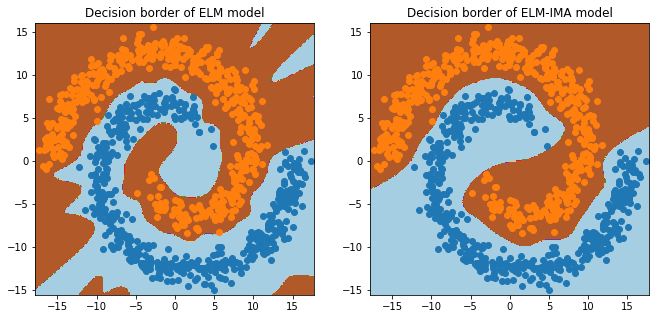

In [59]:
plots(X, y, 100)

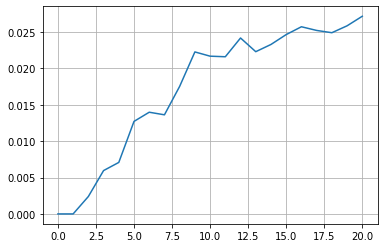

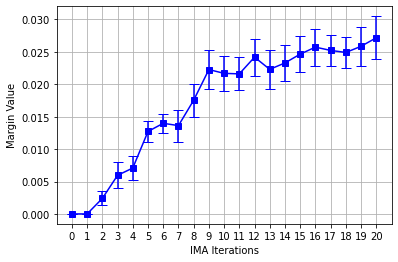

In [60]:
plot_margin_evolution(m)

In [70]:
from sklearn.datasets import make_blobs
centers = [[-2,2],[-2,-2],[2,-2],[2,2]]
X, y = make_blobs(n_samples = 1000, n_features=2, centers=centers, cluster_std=0.6, random_state=50)
y[y%2!=0]=1
y[y%2==0]=-1
m = results(X, y, 100)

*********** Resultado IM ELM com 100 neurônios na camada escondida **************
Acc: 0.9950+/-0.0067
Margin: 0.05378712+/-0.00850499
AUC: 0.9950+/-0.0067
*********** Resultado ELM com 100 neurônios na camada escondida **************
Acc: 0.9960+/-0.0049
Margin: 0.00000032748613+/-0.00000026856208
AUC: 0.9960+/-0.0049


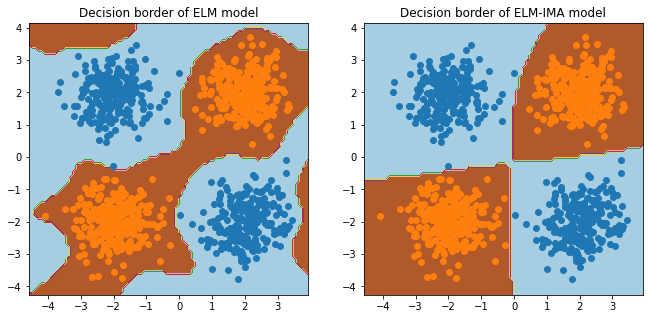

In [71]:
plots(X, y, 100)

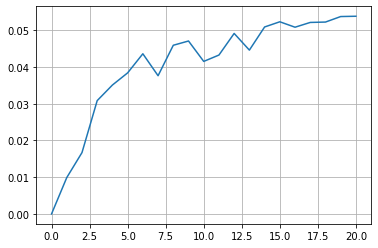

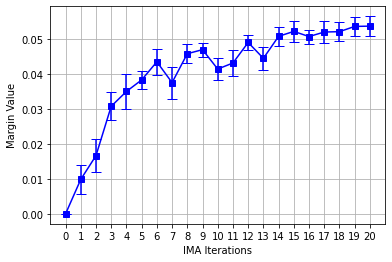

In [72]:
plot_margin_evolution(m)

In [43]:
X, y = datasets.make_circles(n_samples=1000, factor=0.4, noise=0.07)
y[y%2!=0]=1
y[y%2==0]=-1
m = results(X, y, 100)

*********** Resultado IM ELM com 100 neurônios na camada escondida **************
Acc: 1.0000+/-0.0000
Margin: 0.02544234+/-0.00302564
AUC: 1.0000+/-0.0000
*********** Resultado ELM com 100 neurônios na camada escondida **************
Acc: 0.9980+/-0.0060
Margin: 0.00000000000083+/-0.00000000000053
AUC: 0.9980+/-0.0060


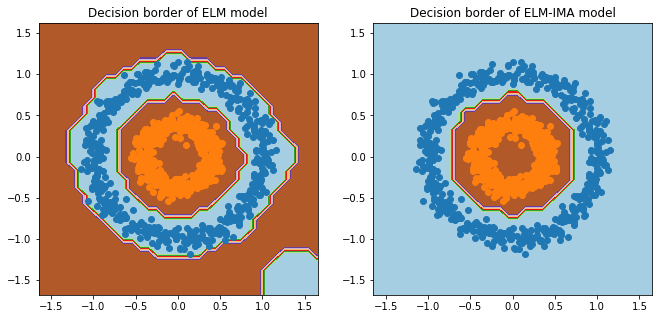

In [44]:
plots(X, y, 100)

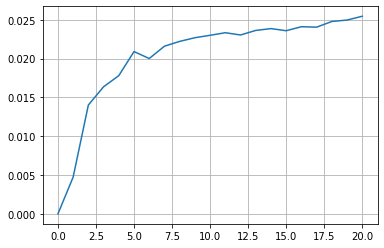

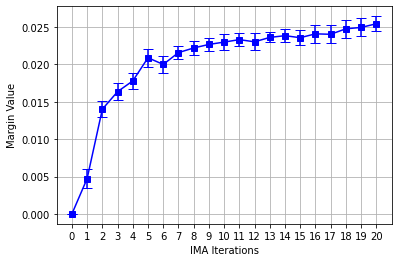

In [45]:
plot_margin_evolution(m)

In [17]:
from sklearn.datasets import make_blobs
centers = [[-2,0],[2,0]]
X, y = make_blobs(n_samples = 1000, n_features=2, centers=centers, cluster_std=0.6)
y[y%2!=0]=1
y[y%2==0]=-1
m = results(X, y, 100)

*********** Resultado IM ELM com 100 neurônios na camada escondida **************
Acc: 0.9990+/-0.0030
Margin: 0.57822564+/-0.22342227
AUC: 0.9990+/-0.0030
*********** Resultado ELM com 100 neurônios na camada escondida **************
Acc: 0.9940+/-0.0066
Margin: 0.00000002326009+/-0.00000001658086
AUC: 0.9940+/-0.0066


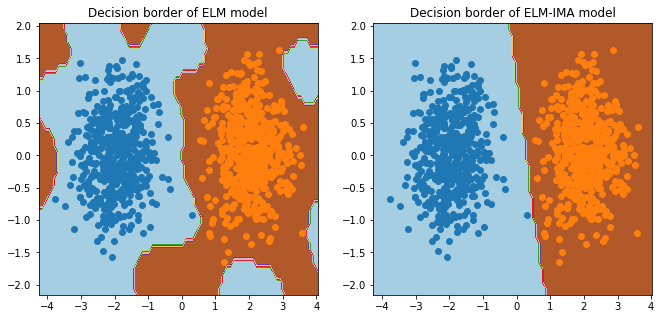

In [18]:
plots(X, y, 100)

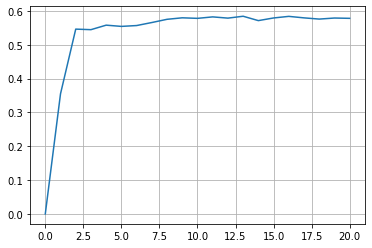

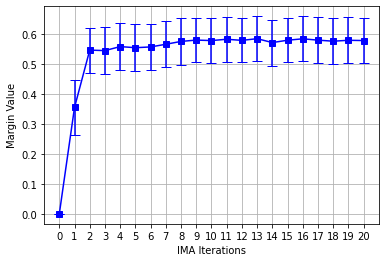

In [19]:
plot_margin_evolution(m)